### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 10,8

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
437,PSID253,0,21,9,1,0,0,1,1030.5740,470.85480,1223.558
290,PSID106,0,34,11,0,0,1,1,0.0000,4010.32300,18133.180
403,PSID219,0,16,7,0,0,0,1,0.0000,975.72580,4728.725
506,PSID322,0,23,12,0,0,0,0,3893.0630,0.00000,16324.450
155,NSW156,1,25,13,1,0,0,0,12362.9300,3090.73200,0.000
475,PSID291,0,16,6,1,0,0,1,0.0000,44.75806,0.000
382,PSID198,0,21,14,0,0,0,0,8456.1960,1330.21000,16967.260
46,NSW47,1,17,8,1,0,0,1,0.0000,0.00000,0.000
136,NSW137,1,23,8,0,0,1,1,0.0000,1713.15000,4232.309
274,PSID90,0,29,10,0,0,1,1,713.1731,4542.04800,7781.708


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
re78_treat = df[df['treat']==1]
re78_contr = df[df['treat']==0]

In [4]:
print("The mean of the treated participants: {tr:.3f}\nThe mean of the control participants: {co:.3f}".format(tr=re78_treat['re78'].mean(),co=re78_contr['re78'].mean()) )

The mean of the treated participants: 6349.144
The mean of the control participants: 6984.170


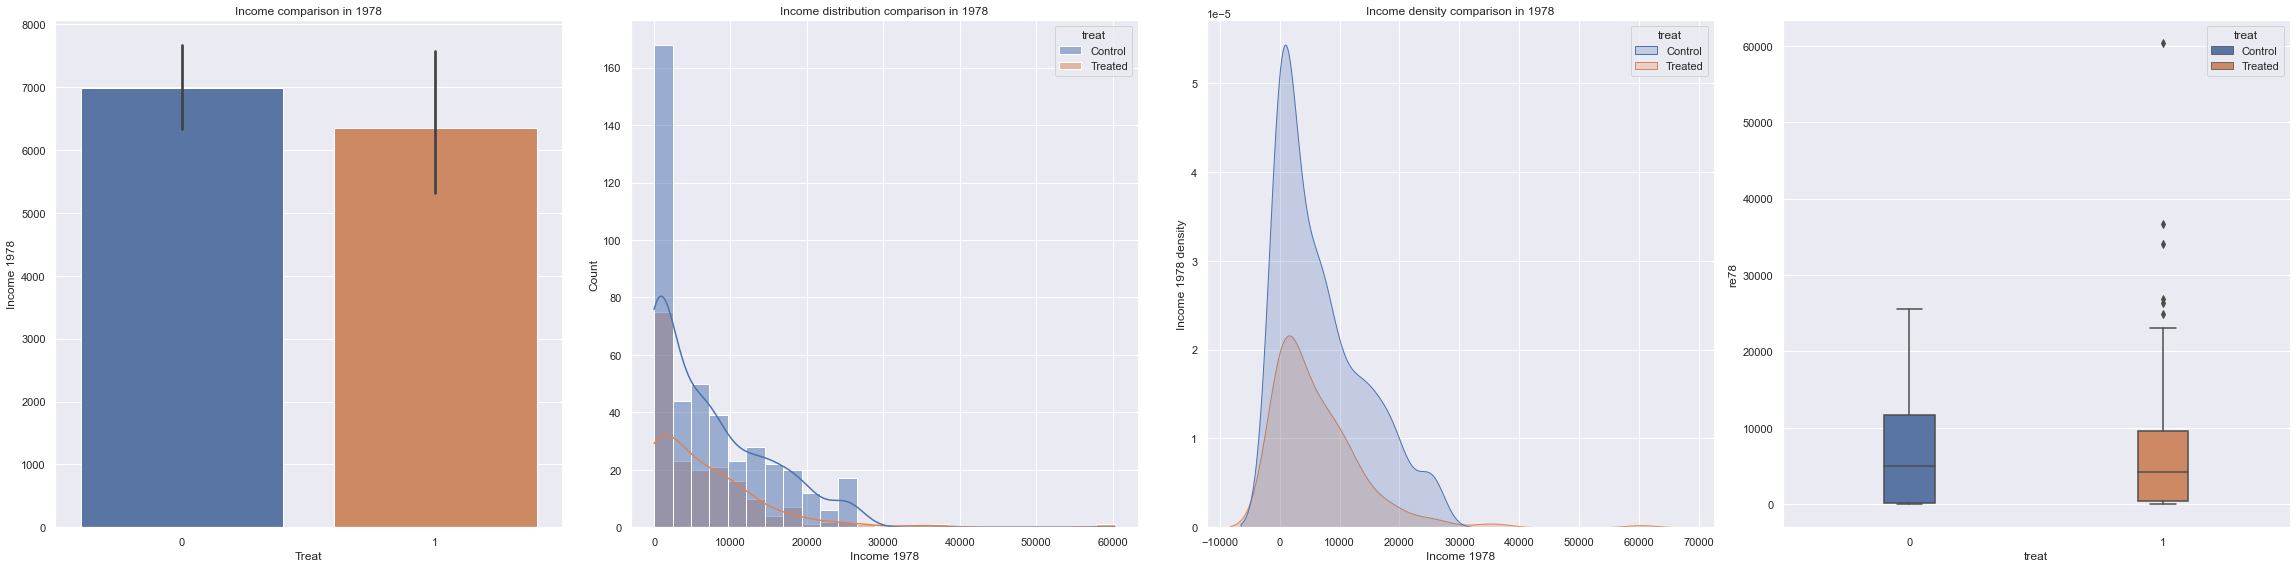

In [5]:
fig, axs = plt.subplots(1,4,figsize=(32,8))

axs = axs.flatten()
#subplot 1
sns.barplot(x="treat",y="re78", data=df, estimator=np.mean, ax=axs[0])
axs[0].set(title='Income comparison in 1978',ylabel='Income 1978', xlabel='Treat')

#subplot 2
ax = sns.histplot(df, x='re78', hue="treat", kde=True, ax=axs[1])
axs[1].set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Count')
#fix the legend
leg = fig.axes[1].get_legend()
new_labels = ['Control', 'Treated']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
#subplot 3
ax = sns.kdeplot(data=df, x="re78", hue="treat", fill=True, ax=axs[2])
axs[2].set(title='Income density comparison in 1978',ylabel='Income 1978 density', xlabel='Income 1978')
#fix the legend
leg = fig.axes[2].get_legend()
new_labels = ['Control', 'Treated']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
#subplot 4
ax = sns.boxplot(data=df, x="treat", y="re78", hue="treat", width=0.2, dodge=False, ax=axs[3])
#fix the legend
leg = fig.axes[3].get_legend()
new_labels = ['Control', 'Treated']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
fig.tight_layout()
plt.show()

The treated group has:

1. lower mean earnings value
2. higher first (25%) percentile - low income interval (though)
3. Some outliers of really high income rates - with maximum income

The control group has:
1. higher mean earnings value
2. higher percentile (50%,75%)
3. higher number of people with income in the interval 12000 - 27000

We conclude that, in general, the control group outperforms the treated one in most of the cases.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [6]:
def plot_income_dist(df, feature):
    fig, axs = plt.subplots(1,4,figsize=(32,8))
    
    switcher = {
        're78': '1978',
        're74': '1974',
        're75': '1975'
    }
    
    year = switcher[feature]
    axs = axs.flatten()
    #subplot 1
    sns.barplot(x="treat",y=feature, data=df, estimator=np.mean, ax=axs[0])
    axs[0].set(title='Income comparison in {}'.format(year),ylabel='Income {}'.format(year), xlabel='Treat')

    #subplot 2
    ax = sns.histplot(df, x=feature, hue="treat", kde=True, ax=axs[1])
    axs[1].set(title='Income distribution comparison in {}'.format(year),xlabel='Income {}'.format(year), ylabel='Count')
    #fix the legend
    leg = fig.axes[1].get_legend()
    new_labels = ['Control', 'Treated']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    #subplot 3
    ax = sns.kdeplot(data=df, x=feature, hue="treat", fill=True, ax=axs[2])
    axs[2].set(title='Income density comparison in {}'.format(year),ylabel='Income {} density'.format(year), xlabel='Income {}'.format(year))
    #fix the legend
    leg = fig.axes[2].get_legend()
    new_labels = ['Control', 'Treated']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    #subplot 4
    ax = sns.boxplot(data=df, x="treat", y=feature, hue="treat", width=0.2, dodge=False, ax=axs[3])
    #fix the legend
    leg = fig.axes[3].get_legend()
    new_labels = ['Control', 'Treated']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)
    fig.tight_layout()
    plt.show()

#### Income: (1974, 1975, 1978)

**Pre-Treatment:**

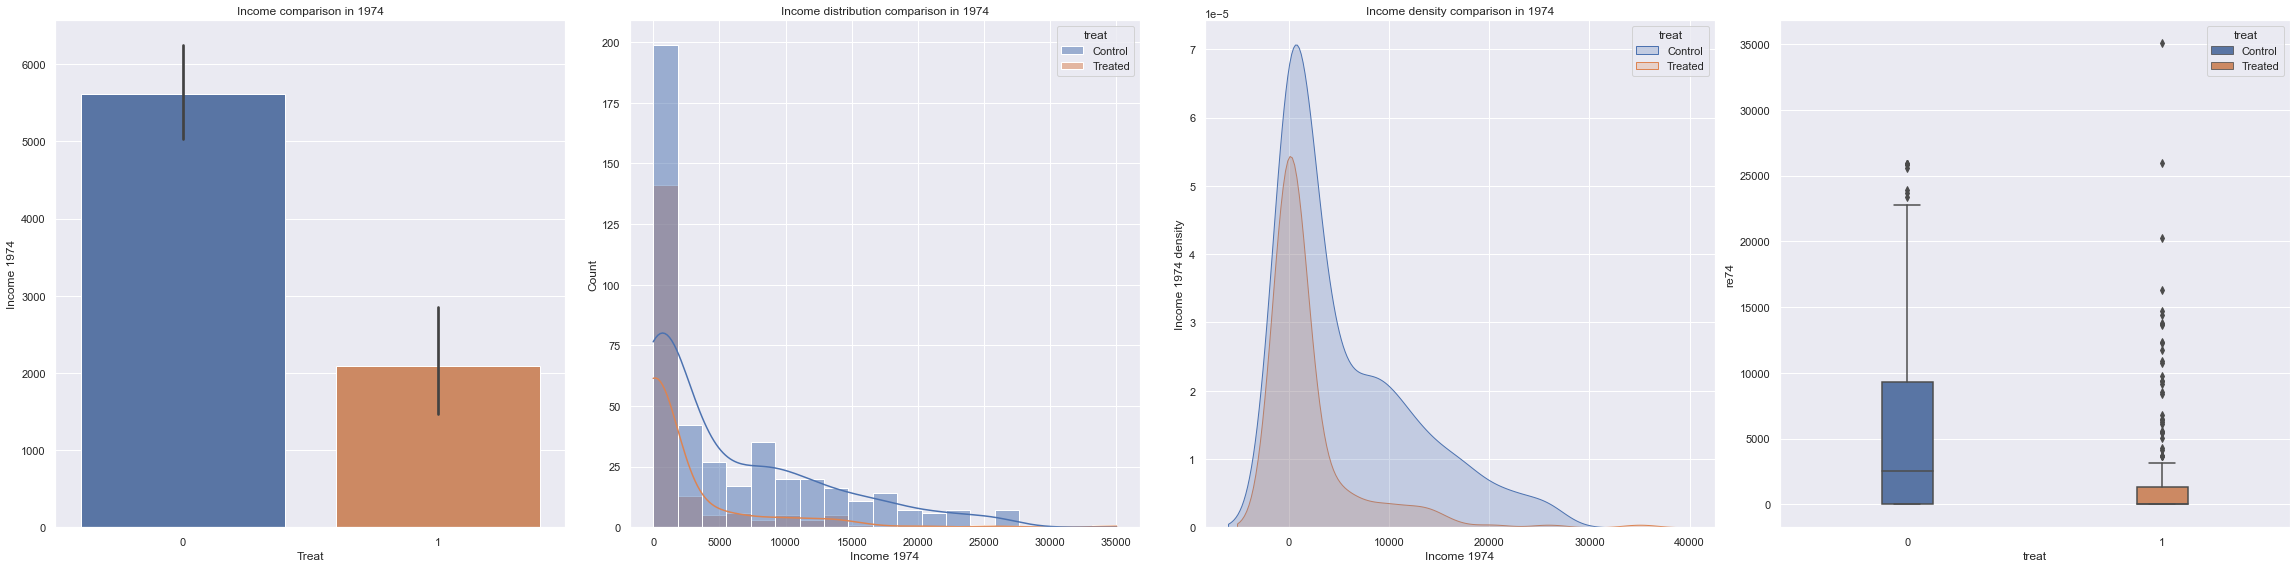

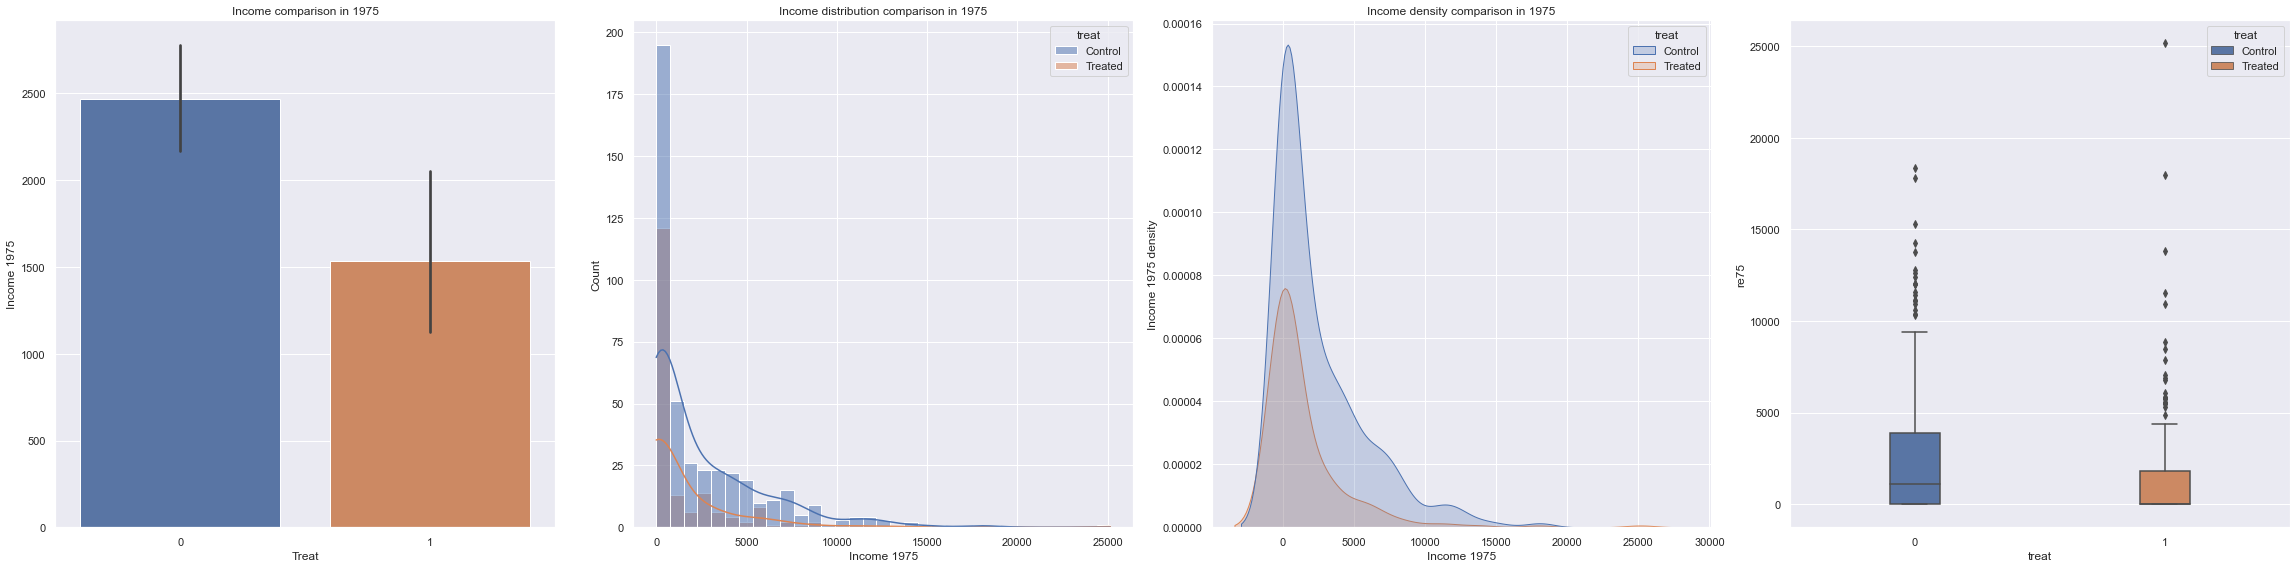

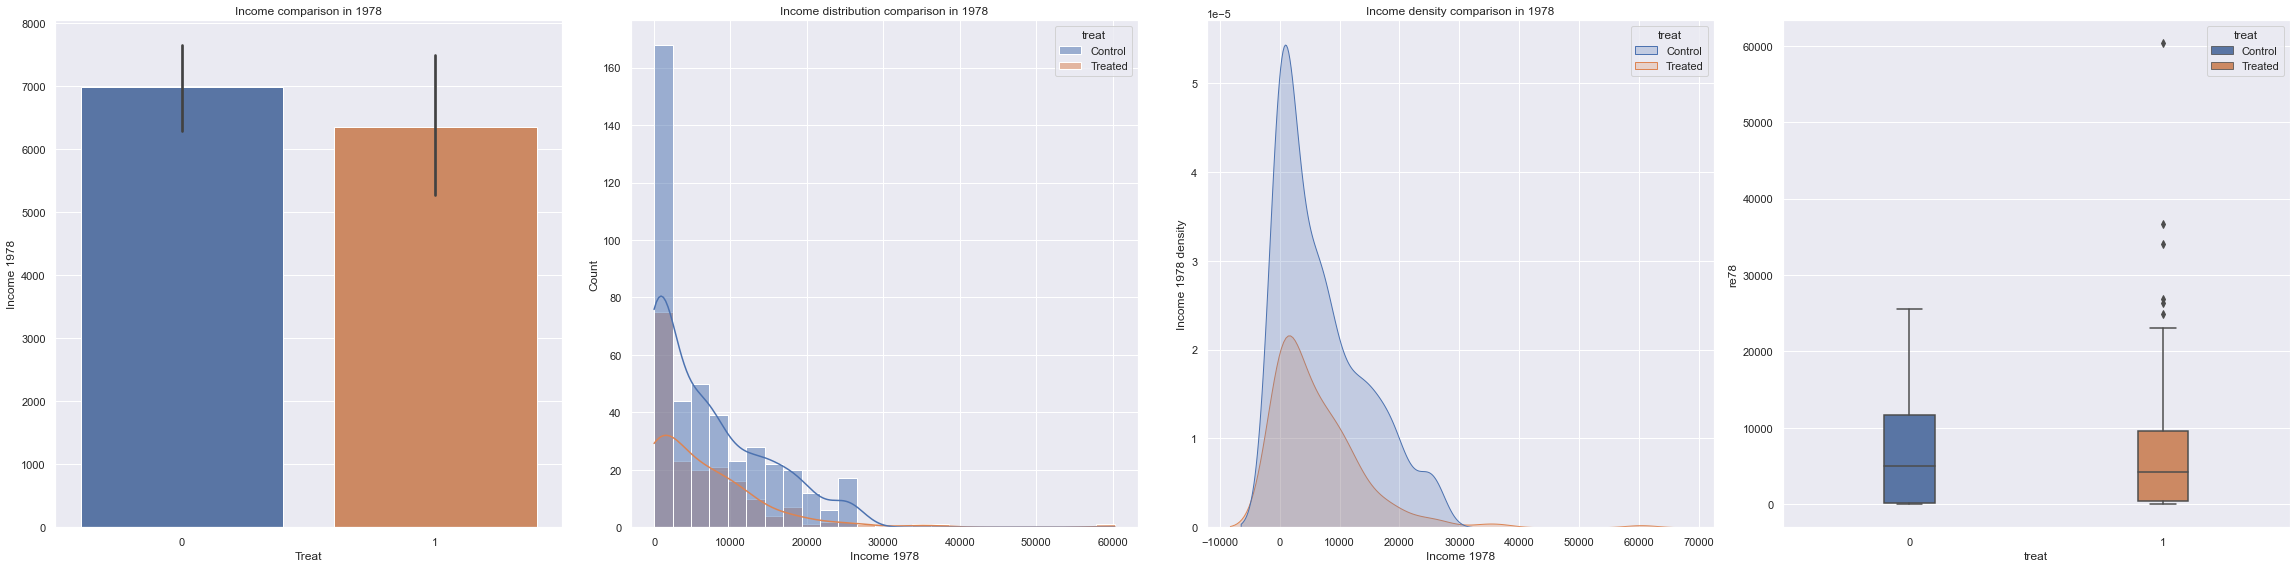

In [42]:
plot_income_dist(df,"re74")
plot_income_dist(df,"re75")
plot_income_dist(df,"re78")

We can see that the income in the previous years (before treatment) of the treated group was low compared to the result. This suggests that an important proportion of the treated people got employed independtly from their salaries. So this might give us an intuition of how much the program helped people to find a job.

#### Age:

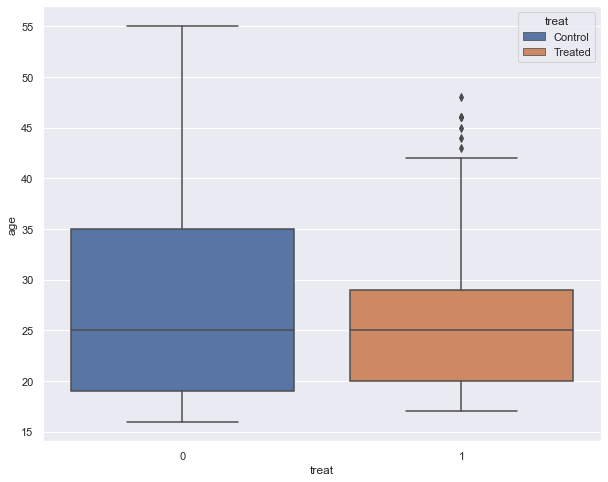

In [10]:
ax = sns.boxplot(data=df, x='treat', hue='treat', y='age', dodge=False)
fig = plt.gcf()
fig.set_size_inches(10, 8)
#fix the legend
leg = ax.get_legend()
new_labels = ['Control', 'Treated']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
plt.show()

The age group of the people getting the treatment is quite young. we have some outliers of older people getting involved in the treatment but we can see that the interval of ages if between 20 and 28 years old.

#### Years of education:

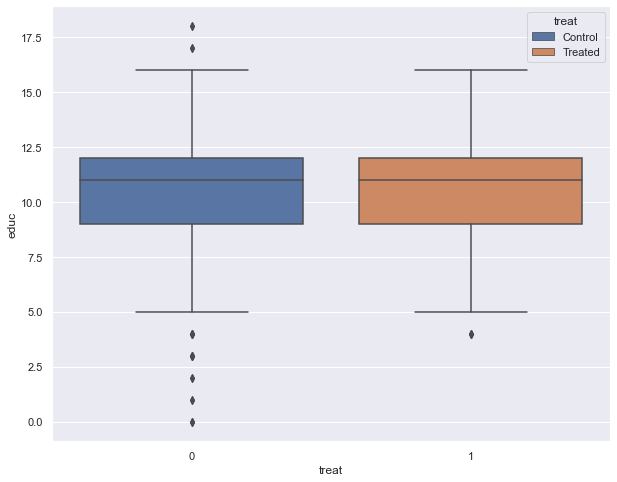

In [11]:
ax = sns.boxplot(data=df, x='treat', hue='treat', y='educ', dodge=False)
fig = plt.gcf()
fig.set_size_inches(10, 8)
#fix the legend
leg = ax.get_legend()
new_labels = ['Control', 'Treated']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
plt.show()

We see that the treated group has more education years than the control group. The percentiles of the two groups coincide, but the control gruoup has more outliers with some having 0 education years.

#### Degree:
- if the subject has earned a school degree: 1 if he hasn't

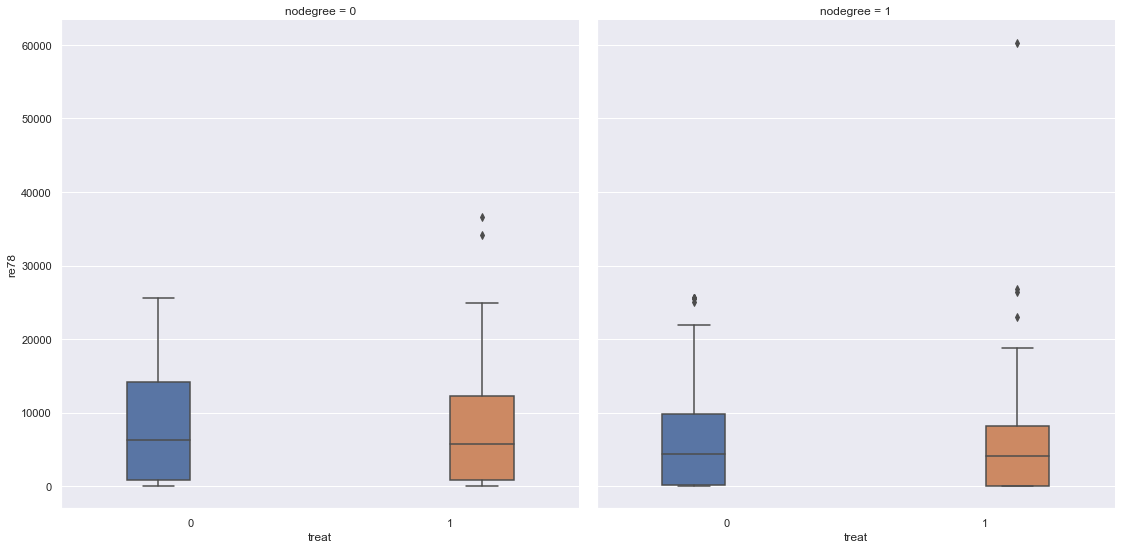

In [38]:
g = sns.catplot(x="treat", hue="treat", y="re78", col="nodegree", data=df, kind="box", legend=True, width=0.5)
fig = plt.gcf()
fig.set_size_inches(16, 8)

We can see that the advantages of the treatment are more apparent with people who have earned a school degree. 

#### Marriage:

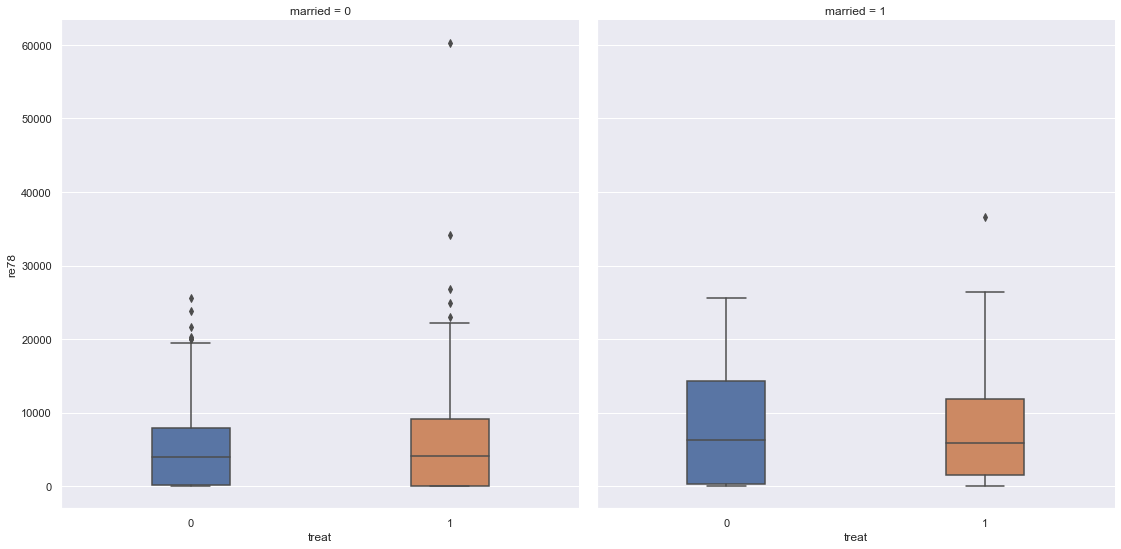

In [40]:
g = sns.catplot(x="treat", y="re78", col="married", data=df, kind="box", width=0.3)
fig = plt.gcf()
fig.set_size_inches(16, 8)

From the plots we can infer that marriage is somehow correlated with more earnings. As this is the result in the treated and control group.

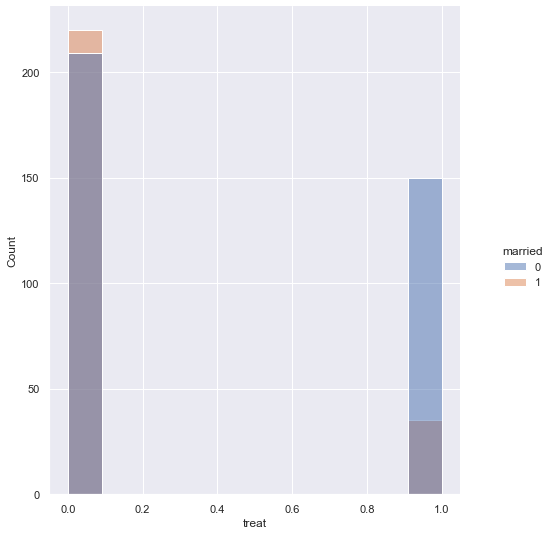

In [48]:
g = sns.displot(x="treat", hue="married", data=df)
fig = plt.gcf()
fig.set_size_inches(8, 8)

We can see that most of the trated people are married. This may gives us more details about the people that are more susceptible for the treatment.

#### Race:

In [15]:
def race(row):
    race = 'white'
    if row['hispan']:
        race = 'hispanic'
    elif row['black']:
        race = 'black'    
    return race
       
df['race'] = df.apply(race, axis=1)

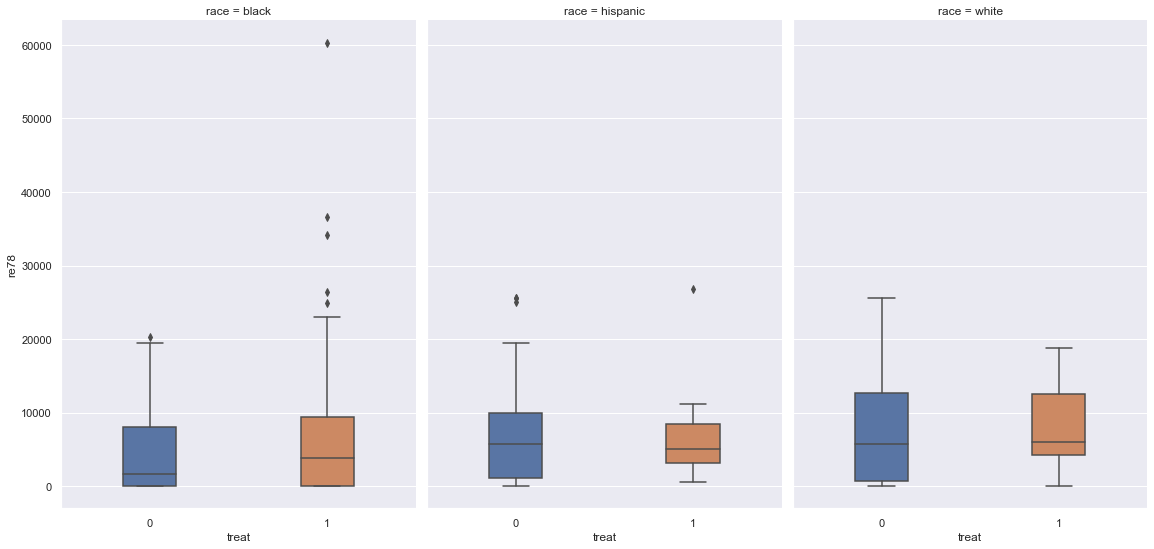

In [41]:
g = sns.catplot(x="treat", y="re78", col="race", data=df, kind="box", width=0.3)
fig = plt.gcf()
fig.set_size_inches(16, 8)

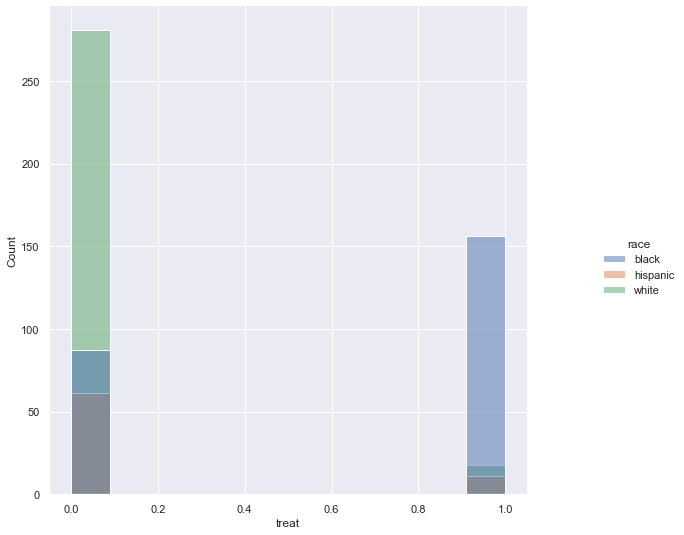

In [53]:
g = sns.displot(x="treat", hue="race", data=df)
fig = plt.gcf()
fig.set_size_inches(10, 8)

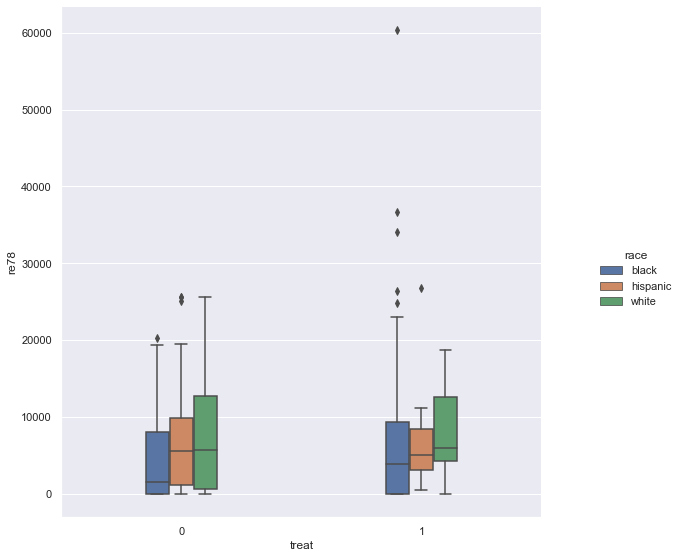

In [50]:
g = sns.catplot(x="treat", y="re78", hue="race", data=df, kind="box", width=0.3)
fig = plt.gcf()
fig.set_size_inches(10, 8)

We can see that the treated group has more black people and the boxplots show that these people earned more as a result of the treatment too. In addition, white outnumber the other races in the control group, and on the other hand, in the treated group the proportion of black is almost the only one.

---

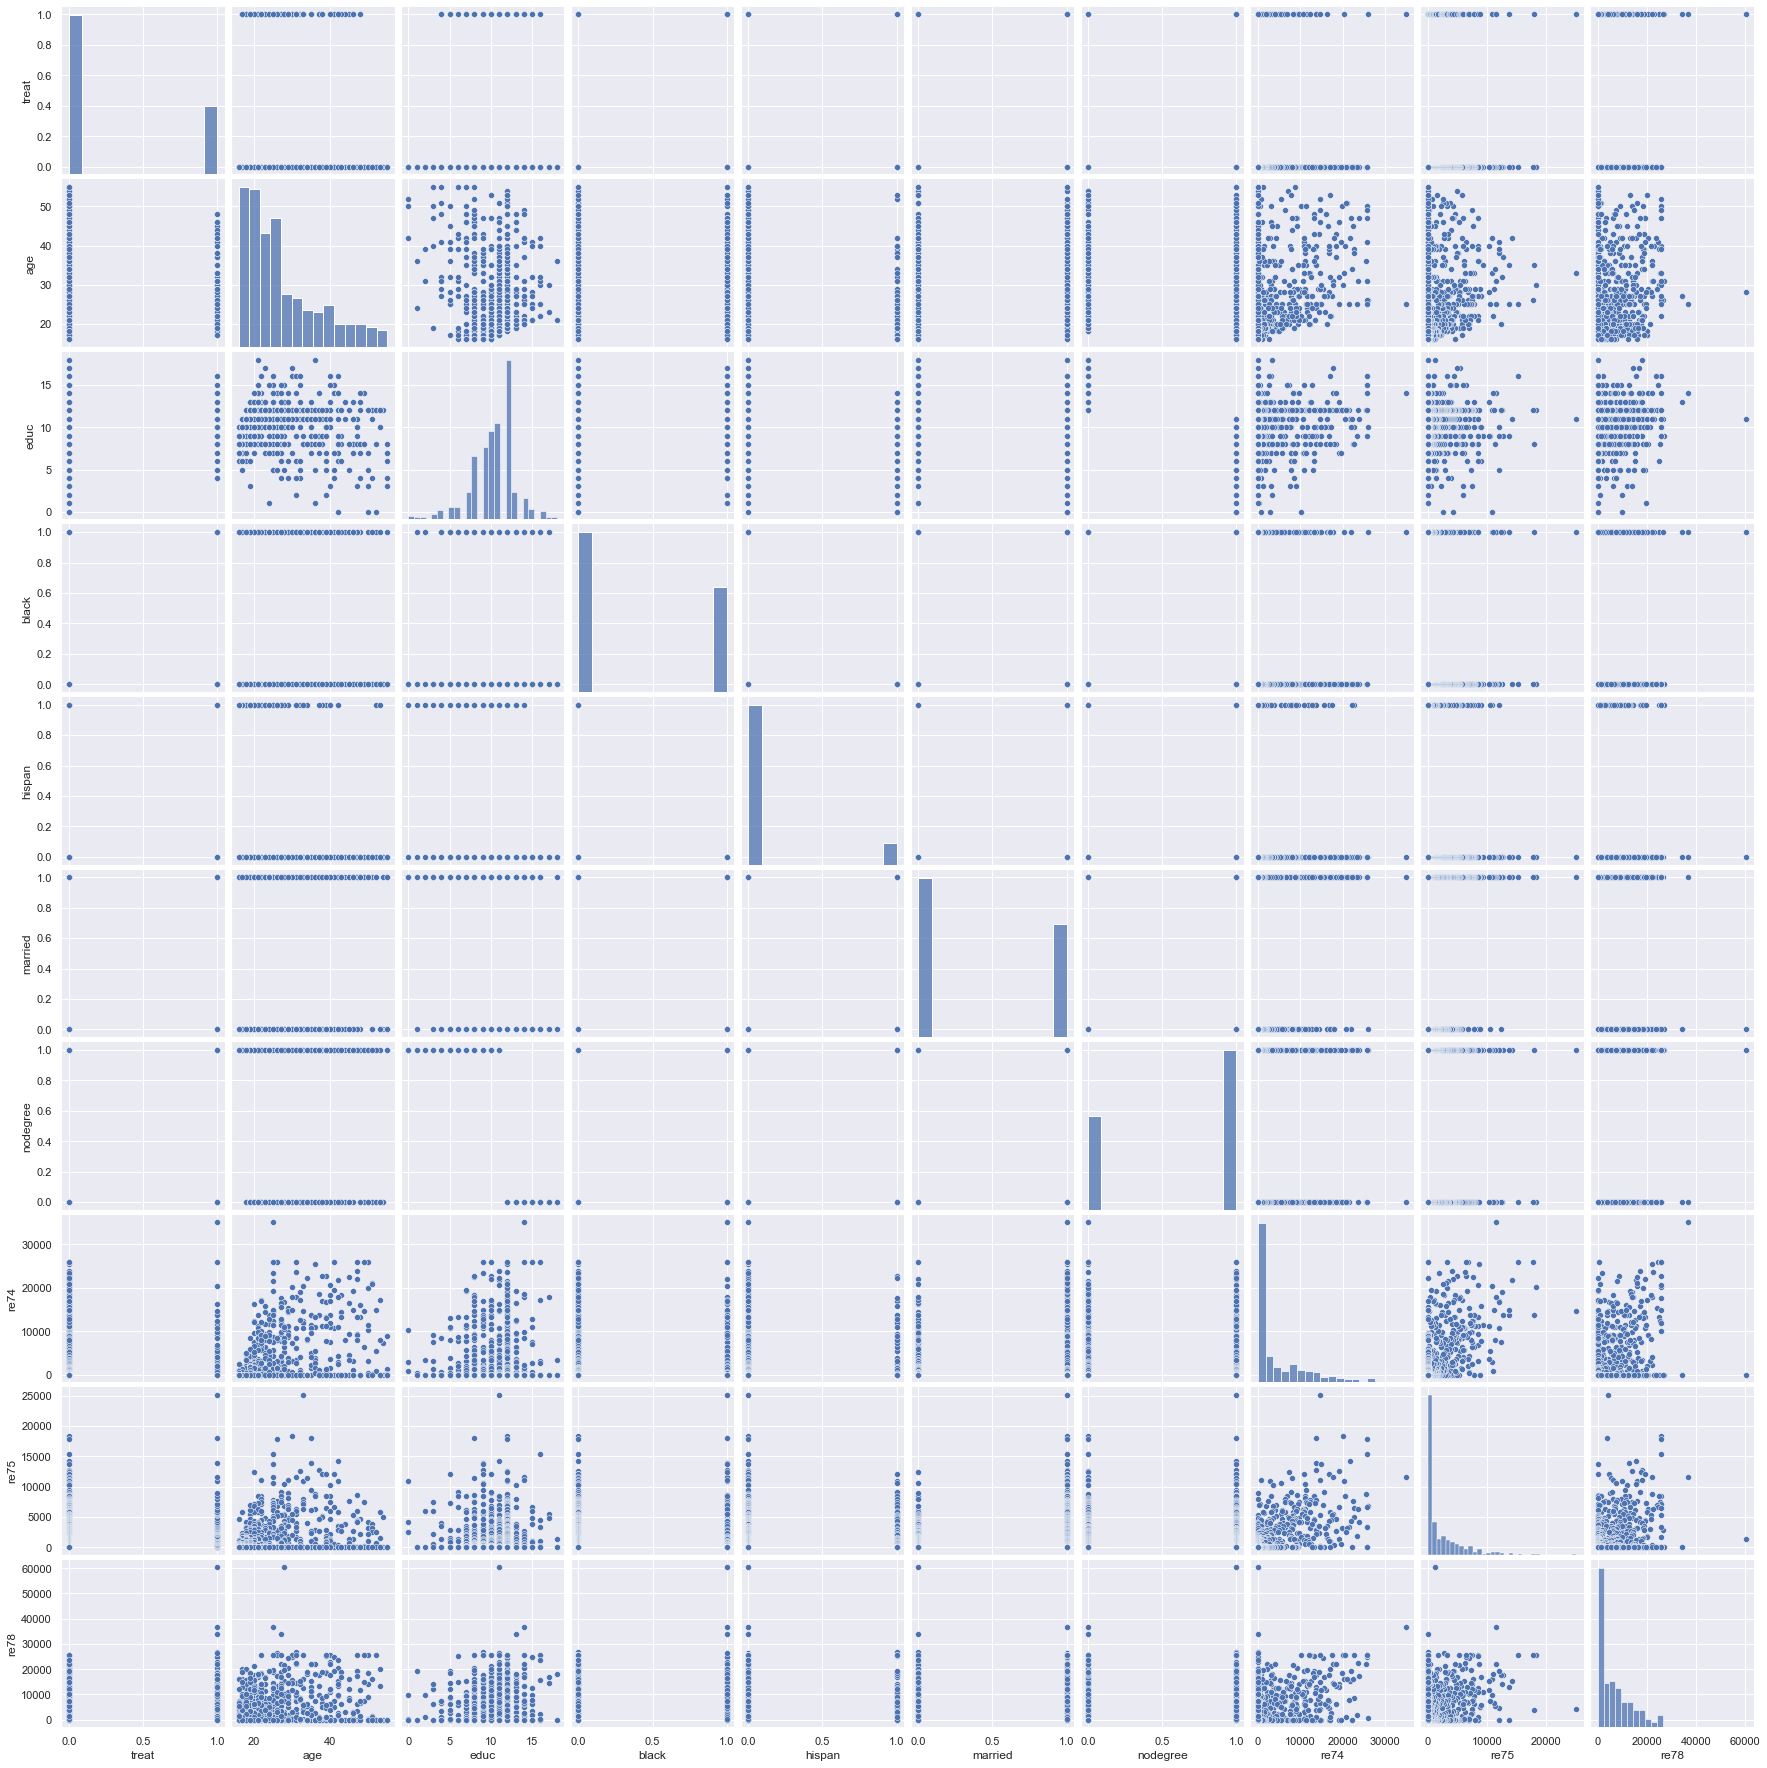

In [109]:
#worst visualization
fg = sns.pairplot(df)

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [5]:
''' your code and explanations ''';

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [7]:
''' your code and explanations ''';

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [8]:
''' your code and explanations ''';

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [9]:
''' your code and explanations ''';